In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import tensor_util
from tensorflow_probability.python.internal import tensorshape_util

In [2]:
import matplotlib.pylab as plt

In [3]:
from tensorflow_probability.python.internal import tensorshape_util

In [4]:
import pandas as pd

# Helper Functions

In [5]:
import functools

def debug(func):
    """Print the function signature and return value"""
    @functools.wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]                      # 1
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]  # 2
        signature = ", ".join(args_repr + kwargs_repr)           # 3
        print(f"Calling {func.__name__}({signature})")
        value = func(*args, **kwargs)
        print(f"{func.__name__!r} returned {value!r}")           # 4
        return value
    return wrapper_debug

In [6]:
def for_all_methods(decorator):
    def decorate(cls):
        for attr in cls.__dict__: # there's propably a better way to do this
            if callable(getattr(cls, attr)):
                setattr(cls, attr, decorator(getattr(cls, attr)))
        return cls
    return decorate

# Quantile Distribution Wrapper

[ 6.78621891e+00  6.58680752e+00  6.38739612e+00  6.18798473e+00
  5.98857334e+00  5.78916195e+00  5.58975056e+00  5.39033917e+00
  5.19092778e+00  4.99151639e+00  4.79210499e+00  4.59269360e+00
  4.39328221e+00  4.19387082e+00  3.99445943e+00  3.79504804e+00
  3.59563665e+00  3.39622526e+00  3.19681386e+00  2.99740247e+00
  2.79799108e+00  2.59857969e+00  2.39916830e+00  2.19975691e+00
  2.00034552e+00  1.80093413e+00  1.60152274e+00  1.40211134e+00
  1.20269995e+00  1.00328856e+00  8.03877171e-01  6.04465780e-01
  4.05054388e-01  2.05642997e-01  6.23160597e-03 -1.93179785e-01
 -3.85234056e-01 -5.63036129e-01 -7.11726834e-01 -8.43978522e-01
 -9.25188767e-01 -9.77006358e-01 -9.93701317e-01 -9.55525890e-01
 -8.93767287e-01 -7.83191484e-01 -6.44670929e-01 -4.85131411e-01
 -2.95740165e-01 -1.01084354e-01  1.01084354e-01  2.95740165e-01
  4.85131411e-01  6.44670929e-01  7.83191484e-01  8.93767287e-01
  9.55525890e-01  9.93701317e-01  9.77006358e-01  9.25188767e-01
  8.43978522e-01  7.11726

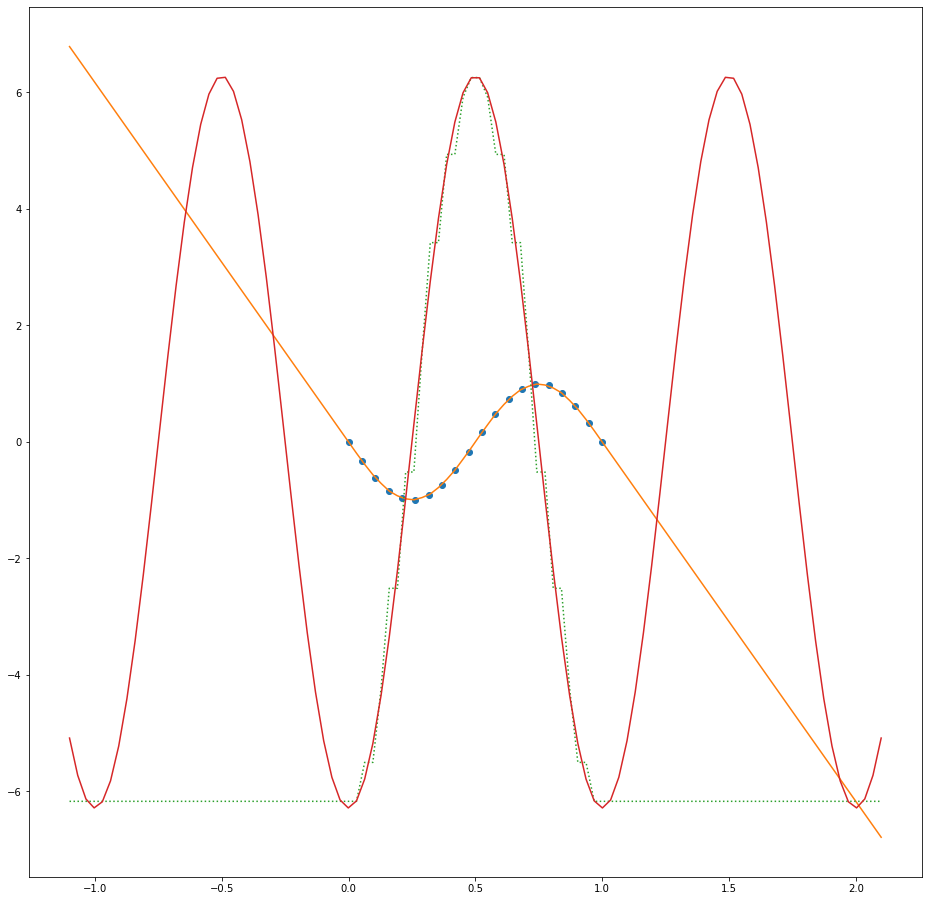

In [121]:
from scipy import interpolate
import scipy as sci
x = np.linspace(0, 1, 20)
y = np.sin(-x*2*np.pi)
f = interpolate.interp1d(x, y, bounds_error=False, fill_value='extrapolate')

h = 1e-10
xnew = np.linspace(-1.1, 2.1, 100)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
print(ynew)
fig =plt.figure(figsize=(16,16))
plt.plot(x, y, 'o', xnew, ynew, '-', xnew, (f(xnew + h) - f(xnew - h))/ (2*h), ':', xnew, -2*np.pi*np.cos(xnew*2*np.pi))
plt.show()

# Normal vs Wrapper

In [45]:
def gen_dist (batch_shape):
    order=5
    if batch_shape != []:
        n=tfd.Normal(loc=tf.zeros((batch_shape)), scale=tf.ones((batch_shape)))
        bs = QuantileRegressionDistributionWrapper(tf.broadcast_to(tf.linspace(0.1,2,100),batch_shape + [100]))
    else:
        n=tfd.Normal(loc=tf.zeros((1)), scale=tf.ones((1)))
        bs = QuantileRegressionDistributionWrapper(tf.linspace(0.1,2,100))
    return n, bs

In [46]:
result={}
batch_sizes=[[], [1], [10], [10,2]]
inputs=np.concatenate([[b,[1]+b,b+[1]] for b in batch_sizes if b != []]).tolist()

for batch_size in batch_sizes:
    n, bs = gen_dist(batch_size)

    print(f'n: {n}')
    print(f'bs: {bs}')

    tmp_res={}

    for i in inputs:
        try:
            tmp_res[f'n.prob({i})'] = str(n.prob(tf.ones(i)).shape)
        except Exception as e:
            tmp_res[f'n.prob({i})'] = 'E'#str(e)
        try:
            tmp_res[f'n.quantile({i})'] = str(n.quantile(0.5).shape)
        except Exception as e:
            tmp_res[f'n.quantile({i})'] = 'E'#str(e)
        try:
            tmp_res[f'bs.prob({i})'] = str(bs.prob(tf.ones(i)).shape)
        except Exception as e:
            tmp_res[f'bs.prob({i})'] = 'E'#str(e)
        try:
            tmp_res[f'bs.quantile({i})'] = str(bs.quantile(0.5).shape)
        except Exception as e:
            tmp_res[f'bs.quantile({i})'] = 'E'#str(e)
    result[str(batch_size)]=tmp_res

n: tfp.distributions.Normal("Normal", batch_shape=[1], event_shape=[], dtype=float32)
bs: tfp.distributions.QuantileRegressionDistributionWrapper("QuantileDistributionWrapper", batch_shape=[1], event_shape=[], dtype=float32)
n: tfp.distributions.Normal("Normal", batch_shape=[1], event_shape=[], dtype=float32)
bs: tfp.distributions.QuantileRegressionDistributionWrapper("QuantileDistributionWrapper", batch_shape=[1], event_shape=[], dtype=float32)
n: tfp.distributions.Normal("Normal", batch_shape=[10], event_shape=[], dtype=float32)
bs: tfp.distributions.QuantileRegressionDistributionWrapper("QuantileDistributionWrapper", batch_shape=[10], event_shape=[], dtype=float32)
n: tfp.distributions.Normal("Normal", batch_shape=[10, 2], event_shape=[], dtype=float32)
bs: tfp.distributions.QuantileRegressionDistributionWrapper("QuantileDistributionWrapper", batch_shape=[10, 2], event_shape=[], dtype=float32)


In [14]:
df=pd.DataFrame(result)

In [15]:
df.index=pd.MultiIndex.from_frame(df.index.str.extract('(n|bs).*(prob|quantile)\((.*)\)'),
                                  names=['dist','op','shape'])
df

[]         [1]         [10]     [10, 2]
dist op       shape                                                      
n    prob     [1]               (1,)        (1,)        (10,)     (10, 2)
     quantile [1]               (1,)        (1,)        (10,)     (10, 2)
bs   prob     [1]               (1,)        (1,)        (10,)     (10, 2)
     quantile [1]               (1,)        (1,)        (10,)     (10, 2)
n    prob     [1, 1]          (1, 1)      (1, 1)      (1, 10)     (10, 2)
     quantile [1, 1]            (1,)        (1,)        (10,)     (10, 2)
bs   prob     [1, 1]          (1, 1)      (1, 1)      (1, 10)     (10, 2)
     quantile [1, 1]            (1,)        (1,)        (10,)     (10, 2)
n    prob     [10]             (10,)       (10,)        (10,)           E
     quantile [10]              (1,)        (1,)        (10,)     (10, 2)
bs   prob     [10]             (10,)       (10,)        (10,)           E
     quantile [10]              (1,)        (1,)        (10,)     (10, 2)
n    prob     [1, 10]        (1, 10)     (1, 10)      (1, 10)           E
     quantile [1, 10]           (1,)        (1,)        (10,)     (10, 2)
bs   prob     [1, 10]        (1, 10)     (1, 10)      (1, 10)           E
     quantile [1, 10]           (1,)        (1,)        (10,)     (10, 2)
n    prob     [10, 1]        (10, 1)     (10, 1)     (10, 10)     (10, 2)
     quantile [10, 1]           (1,)        (1,)        (10,)     (10, 2)
bs   prob     [10, 1]        (10, 1)     (10, 1)     (10, 10)           E
     quantile [10, 1]           (1,)        (1,)        (10,)     (10, 2)
n    prob     [10, 2]        (10, 2)     (10, 2)            E     (10, 2)
     quantile [10, 2]           (1,)        (1,)        (10,)     (10, 2)
bs   prob     [10, 2]        (10, 2)     (10, 2)            E     (10, 2)
     quantile [10, 2]           (1,)        (1,)        (10,)     (10, 2)
n    prob     [1, 10, 2]  (1, 10, 2)  (1, 10, 2)            E  (1, 10, 2)
     quantile [1, 10, 2]        (1,)        (1,)        (10,)     (10, 2)
bs   prob     [1, 10, 2]  (1, 10, 2)  (1, 10, 2)            E  (1, 10, 2)
     quantile [1, 10, 2]        (1,)        (1,)        (10,)     (10, 2)
n    prob     [10, 2, 1]  (10, 2, 1)  (10, 2, 1)  (10, 2, 10)           E
     quantile [10, 2, 1]        (1,)        (1,)        (10,)     (10, 2)
bs   prob     [10, 2, 1]  (10, 2, 1)  (10, 2, 1)  (10, 2, 10)           E
     quantile [10, 2, 1]        (1,)        (1,)        (10,)     (10, 2)

In [16]:
df.loc[('n','prob')] == df.loc[('bs','prob')]

<ipython-input-16-2f30e4451992>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('n','prob')] == df.loc[('bs','prob')]


,[],[1],[10],"[10, 2]"
shape,,,,
[1],True,True,True,True
"[1, 1]",True,True,True,True
[10],True,True,True,True
"[1, 10]",True,True,True,True
"[10, 1]",True,True,True,False
"[10, 2]",True,True,True,True
"[1, 10, 2]",True,True,True,True
"[10, 2, 1]",True,True,True,True


In [17]:
df.loc[('n','quantile')] == df.loc[('bs','quantile')]

<ipython-input-17-e69ee47943f4>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('n','quantile')] == df.loc[('bs','quantile')]


,[],[1],[10],"[10, 2]"
shape,,,,
[1],True,True,True,True
"[1, 1]",True,True,True,True
[10],True,True,True,True
"[1, 10]",True,True,True,True
"[10, 1]",True,True,True,True
"[10, 2]",True,True,True,True
"[1, 10, 2]",True,True,True,True
"[10, 2, 1]",True,True,True,True


In [18]:
n, tq = gen_dist ([32,48])
n, tq

(<tfp.distributions.Normal 'Normal' batch_shape=[32, 48] event_shape=[] dtype=float32>,
 <tfp.distributions.QuantileRegressionDistributionWrapper 'QuantileDistributionWrapper' batch_shape=[32, 48] event_shape=[] dtype=float32>)

In [19]:
x=tf.ones((100,32,48))
tq.prob(x).shape,n.prob(x).shape

(TensorShape([100, 32, 48]), TensorShape([100, 32, 48]))